# Read Data and Create Necessary Columns

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy


from IPython.display import display, HTML
from statsmodels.tsa.seasonal import seasonal_decompose

display(HTML("<style>div.output_scroll { height: 25em; }</style>"))
pd.set_option('display.float_format', '{:.3f}'.format)
sns.set(style="whitegrid")

In [2]:
data = pd.read_csv('../data/transactions_ds.csv', sep=';')
del data['price_ttc']

data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.tz_convert('Europe/Paris')

| **Variable** | **Meaning** |
| :-: | :-: |
| item_id | Unique name of item |
| transaction_id | Unique name of transaction |
| quantity | Continious or discrete number of product sold |
| price_ht | Total price for a item (including discounts, coupones)|
| date | Date of an observation |

In [3]:
data['year'] = data['date'].dt.year
data['year_week'] = data['date'].dt.isocalendar().week
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.day_name()

data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute

data['year_week'] = data['year_week'].astype('int64')

Remove dublicates. Example:

In [4]:
data[(data['item_id'] == 7) &
     (data['transaction_id'] == 4)]

,item_id,quantity,price_ht,transaction_id,date,year,year_week,month,day,weekday,hour,minute
10,7,1.000,0.000,4,2018-03-08 14:13:29+01:00,2018,10,3,8,Thursday,14,13
11,7,1.000,0.000,4,2018-03-08 14:13:29+01:00,2018,10,3,8,Thursday,14,13


In [5]:
data = data.groupby(['item_id', 'transaction_id'], as_index=False).first()
data.head(3)

,item_id,transaction_id,quantity,price_ht,date,year,year_week,month,day,weekday,hour,minute
0,0,1,1.000,12.420,2018-03-08 14:10:59+01:00,2018,10,3,8,Thursday,14,10
1,0,3,1.000,10.050,2018-03-08 14:12:18+01:00,2018,10,3,8,Thursday,14,12
2,0,7,1.000,0.000,2018-03-08 14:16:50+01:00,2018,10,3,8,Thursday,14,16


And remove sold goods with negative price (for now, we assume it is an error in the data)

In [6]:
data = data[data['price_ht'] >= 0]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442178 entries, 0 to 442192
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype                       
---  ------          --------------   -----                       
 0   item_id         442178 non-null  int64                       
 1   transaction_id  442178 non-null  int64                       
 2   quantity        442178 non-null  float64                     
 3   price_ht        442178 non-null  float64                     
 4   date            442178 non-null  datetime64[ns, Europe/Paris]
 5   year            442178 non-null  int64                       
 6   year_week       442178 non-null  int64                       
 7   month           442178 non-null  int64                       
 8   day             442178 non-null  int64                       
 9   weekday         442178 non-null  object                      
 10  hour            442178 non-null  int64                       
 11  minute       

# Basic Statistics of the Data

In [8]:
data[['quantity', 'price_ht']].describe()

,quantity,price_ht
count,442178.000,442178.000
mean,1.226,6.024
std,2.838,6.219
min,0.028,0.000
25%,1.000,2.920
50%,1.000,4.640
75%,1.000,7.580
max,1020.000,1160.190


`price_ht` could be zero, if discounts or coupones were used

In [9]:
data.head(4)

,item_id,transaction_id,quantity,price_ht,date,year,year_week,month,day,weekday,hour,minute
0,0,1,1.000,12.420,2018-03-08 14:10:59+01:00,2018,10,3,8,Thursday,14,10
1,0,3,1.000,10.050,2018-03-08 14:12:18+01:00,2018,10,3,8,Thursday,14,12
2,0,7,1.000,0.000,2018-03-08 14:16:50+01:00,2018,10,3,8,Thursday,14,16
3,0,16,1.000,12.230,2018-03-08 15:21:13+01:00,2018,10,3,8,Thursday,15,21


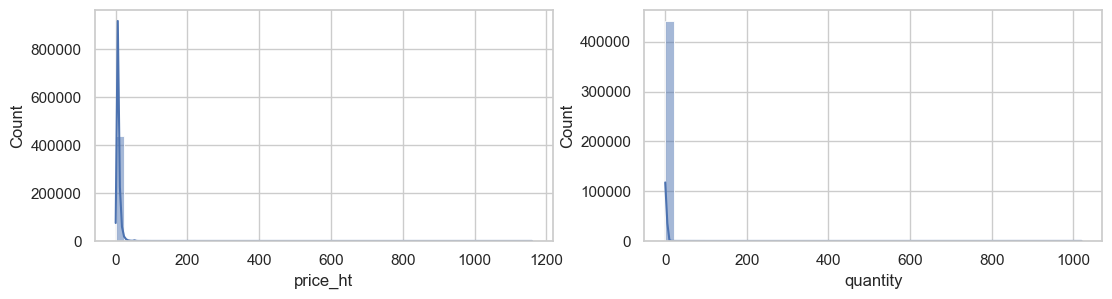

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(13, 3))
sns.histplot(data['price_ht'], kde=True, bins=50, ax=ax[0])
sns.histplot(data['quantity'], kde=True, bins=50, ax=ax[1]);

High peaks for all critical variables, which indicates large number of outliers

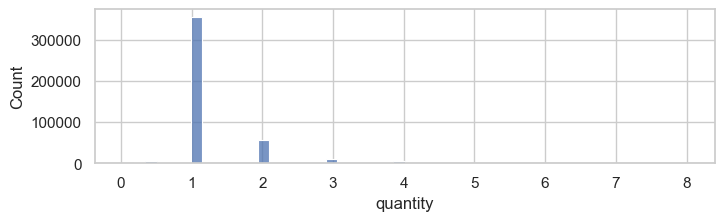

In [11]:
fig, ax = plt.subplots(figsize=(8, 2))
mask = np.abs(scipy.stats.zscore(data[['quantity']])) < 2.5
data = data[mask['quantity']]
sns.histplot(data['quantity'], bins=50, ax=ax);

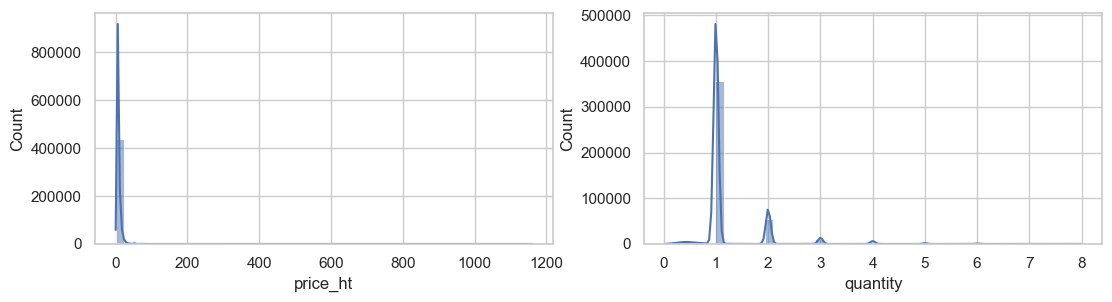

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(13, 3))
sns.histplot(data['price_ht'], kde=True, bins=50, ax=ax[0])
sns.histplot(data['quantity'], kde=True, bins=50, ax=ax[1]);

Now better, but still a lot of products around zero. Why?

In [13]:
data.groupby([pd.cut(data.quantity, [0, 0.25, 0.5, 0.75, 1, 2, 5, 10, 20, 30, 50])]).size()

quantity
(0.0, 0.25]       1743
(0.25, 0.5]       6535
(0.5, 0.75]       4032
(0.75, 1.0]     356774
(1.0, 2.0]       56122
(2.0, 5.0]       15827
(5.0, 10.0]        896
(10.0, 20.0]         0
(20.0, 30.0]         0
(30.0, 50.0]         0
dtype: int64

**Answer:** a lot products that can be sold by weight\
The rest variables also have skewed distribution, but it seems fine, we can scale in for our models with $log$ transformations

## When customers buy  products?

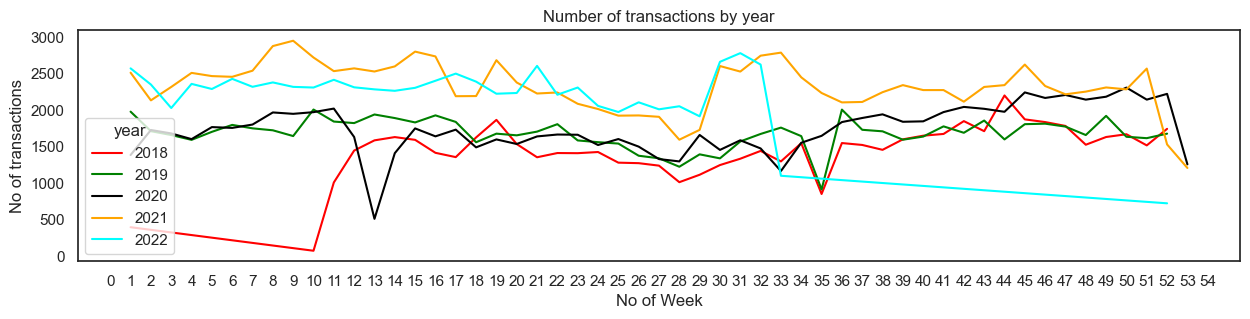

In [14]:
data_yw = data.groupby(['year', 
                        'year_week'])['transaction_id'].count().reset_index().sort_values(by=['year'])

data_yw['year_week'] = data_yw['year_week'].astype('int64')

fig, ax = plt.subplots(figsize=(15, 3))
plot_data_yw = sns.lineplot(data_yw, 
                            x='year_week', 
                            y='transaction_id', 
                            hue='year', 
                            ax=ax,
                            palette=['red', 'green', 'black', 'orange', 'cyan'])
plot_data_yw.set(title='Number of transactions by year',
                 xlabel='No of Week',
                 ylabel='No of transactions')
plot_data_yw.set_xticks(range(55));

Trend isn't tremendously different in COVID year, so we can keep up. But because we don't have any information for some pediods, we can omit observations

In [16]:
data_f = data[~((data['year'] == 2022) & (data['year_week'] > 32)) &
              ~((data['year'] == 2018) & (data['year_week'] < 11))]

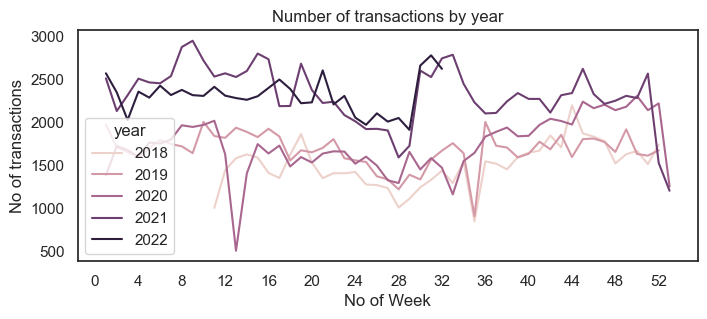

In [79]:
sns.set_theme(style="white", palette=None)

data_yw = data_f.groupby(['year', 
                        'year_week'])['transaction_id'].count().reset_index().sort_values(by=['year'])

data_yw['year_week'] = data_yw['year_week'].astype('int64')

fig, ax = plt.subplots(figsize=(8, 3))
plot_data_yw = sns.lineplot(data_yw, 
                            x='year_week', 
                            y='transaction_id', 
                            hue='year', 
                            ax=ax)
#                            palette=['red', 'green', 'black', 'orange', 'cyan'])
plot_data_yw.set(title='Number of transactions by year',
                 xlabel='No of Week',
                 ylabel='No of transactions')
plot_data_yw.set_xticks(range(0, 55, 4))
fig.savefig('Transactions_by_year.png')

In [23]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data_f.groupby(['weekday'])['transaction_id'].count().reindex(weekdays)

weekday
Monday          431
Tuesday       54687
Wednesday     46581
Thursday      50104
Friday        48883
Saturday      95445
Sunday       143515
Name: transaction_id, dtype: int64

In [29]:
data_f

,item_id,transaction_id,quantity,price_ht,date,year,year_week,month,day,weekday,hour,minute
8,0,114,1.000,0.000,2018-03-16 17:02:58+01:00,2018,11,3,16,Friday,17,2
9,0,115,1.000,0.000,2018-03-16 17:03:11+01:00,2018,11,3,16,Friday,17,3
10,0,151,1.000,9.100,2018-03-17 10:14:19+01:00,2018,11,3,17,Saturday,10,14
11,0,197,1.000,6.540,2018-03-17 11:53:53+01:00,2018,11,3,17,Saturday,11,53
12,0,198,2.000,22.380,2018-03-17 11:58:34+01:00,2018,11,3,17,Saturday,11,58
...,...,...,...,...,...,...,...,...,...,...,...,...
442181,106,310717,2.000,20.090,2022-08-14 13:59:29+02:00,2022,32,8,14,Sunday,13,59
442182,106,310745,1.000,6.260,2022-08-14 14:09:56+02:00,2022,32,8,14,Sunday,14,9
442183,106,310765,1.000,4.830,2022-08-14 14:18:51+02:00,2022,32,8,14,Sunday,14,18
442184,106,310804,1.000,5.500,2022-08-14 14:38:03+02:00,2022,32,8,14,Sunday,14,38


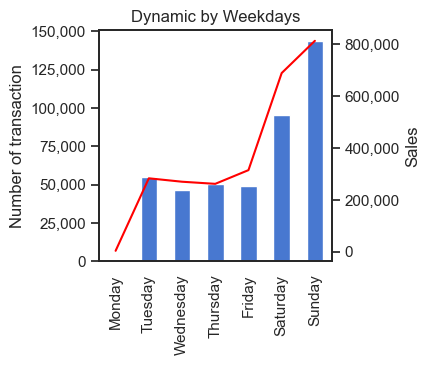

In [116]:
sns.set_theme(style="white", palette=None)
import matplotlib

fig, ax = plt.subplots(figsize=(15, 3))
ax = data_f.groupby(['weekday'])['transaction_id'].count().reindex(weekdays).plot(kind='bar',
                                                                             legend=False,
                                                                             figsize=(3,3),
                                                                             xlabel='')
plt.ylabel('Number of transaction');
ax2 = ax.twinx()
data_f.groupby(['weekday'])['price_ht'].sum().reindex(weekdays).plot(color='red',
                                                                     legend=False,
                                                                     figsize=(3,3),
                                                                     ax=ax2)

plt.ylabel('Sales')
plt.title('Dynamic by Weekdays')

ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

fig.savefig('Sales.png', bbox_inches = "tight")

Seems the bakery is closed on Mondays

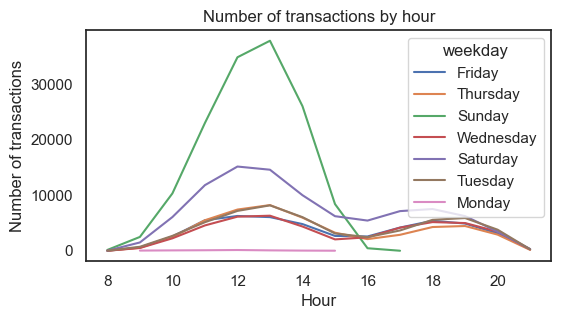

In [73]:
no_trans_by_h = data_f.groupby(['weekday', 'hour'])['transaction_id'].count().reset_index().sort_values(by='hour')

fig, ax = plt.subplots(figsize=(6, 3))
plt_no_trans_by_h = sns.lineplot(no_trans_by_h, 
                                 x='hour', 
                                 y='transaction_id', 
                                 hue='weekday',
                                 #palette=['red', 'green', 'black', 'orange', 'brown', 'purple', 'blue'],
                                 ax=ax)

plt_no_trans_by_h.set(title='Number of transactions by hour',
                      xlabel='Hour',
                      ylabel='Number of transactions');

fig.savefig('pics/Number of transactions by hour.png', bbox_inches = "tight")

Again, seems the bakery is closed on Mondays. Peek hours are 12am-2pm. Sunday is the busiest day of a week

## What are the most popular products?

In [81]:
temp = data_f.groupby(['item_id'])['transaction_id'].count().sort_values(ascending=False).reset_index()
temp['percentage'] = 100 * temp['transaction_id']  / temp['transaction_id'].sum()
top_5_items = temp[['item_id', 'percentage']].head(5)['item_id'].to_list()
temp[['item_id', 'percentage']].head(5)

,item_id,percentage
0,11,13.141
1,55,8.653
2,26,4.425
3,29,4.347
4,28,4.147


When people buy them?

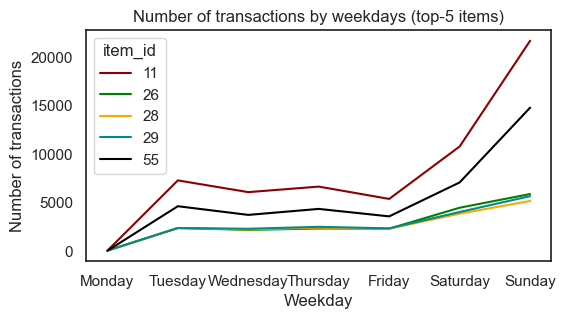

In [115]:
top_5_p_plot = data_f[data_f['item_id'].isin(top_5_items)].groupby(['weekday', 
                                                                    'item_id'])\
                                        ['transaction_id'].count().reset_index()

top_5_p_plot['weekday'] = pd.Categorical(top_5_p_plot['weekday'], categories=weekdays, ordered=True)

fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(top_5_p_plot,
             x='weekday',
             y='transaction_id',
             hue='item_id',
             palette=['darkred', 'green', 'orange', 'darkcyan', 'black'])


ax.set(title='Number of transactions by weekdays (top-5 items)',
       xlabel='Weekday',
       ylabel='Number of transactions')

fig.savefig('pics/Notr_Weekdays.png', bbox_inches = "tight");

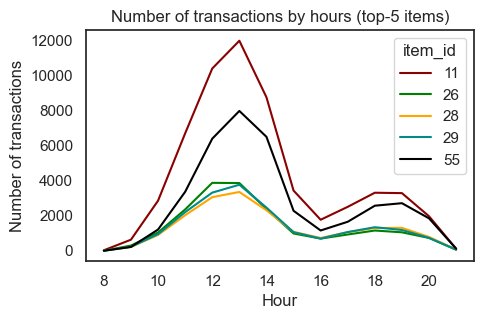

In [113]:
top_5_p_plot = data_f[data_f['item_id'].isin(top_5_items)].groupby(['hour', 
                                                                    'item_id'])\
                                        ['transaction_id'].count().reset_index()



fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(top_5_p_plot,
             x='hour',
             y='transaction_id',
             hue='item_id',
             palette=['darkred', 'green', 'orange', 'darkcyan', 'black'])

ax.set(title='Number of transactions by hours (top-5 items)',
       xlabel='Hour',
       ylabel='Number of transactions')

fig.savefig('pics/Notr_hours.png', bbox_inches = "tight");

No significant pattern fluctuations in products

In [22]:
pivot_items = pd.pivot_table(data_f[['item_id', 'transaction_id', 'year']], 
                             values='transaction_id', 
                             index='item_id',
                             columns='year',
                             aggfunc='count',
                             fill_value=0)

pivot_items.tail()

year,2018,2019,2020,2021,2022
item_id,,,,,
102,0,0,0,0,121
103,0,0,0,0,9
104,0,0,0,0,676
105,0,0,0,0,25
106,0,0,0,0,128


In [23]:
pivot_items.sort_values(by=2022).head()

year,2018,2019,2020,2021,2022
item_id,,,,,
76,2919,8908,3998,1402,0
79,0,1,1,1,0
74,97,91,182,196,0
72,43,49,86,124,0
84,0,1,0,0,0


What we can see is that some products are new (e.g. 102, 103, etc.) and were introduced in 2022. Some of them were not sold in 2022 (76, 79, 74, etc.)

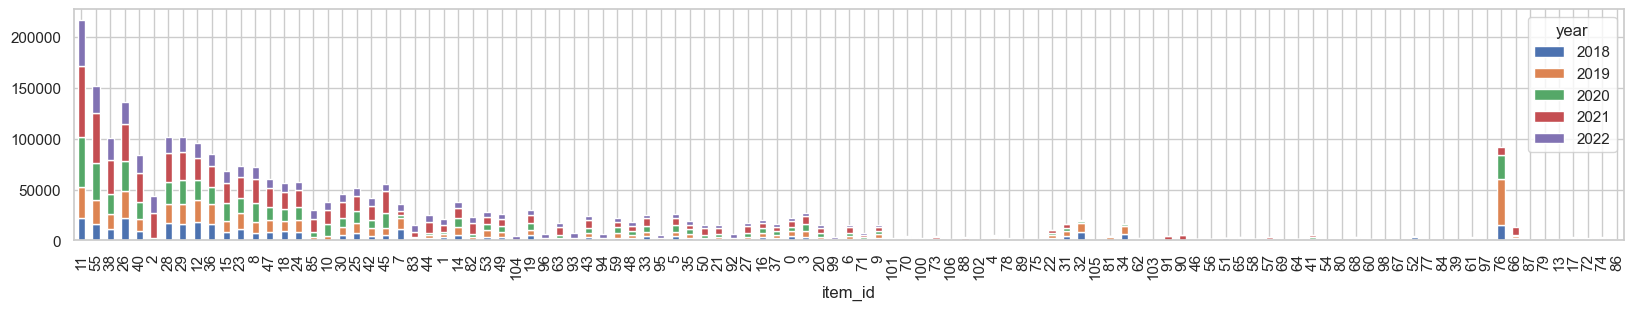

In [24]:
yearly_item = data_f.groupby(['item_id', 
                              'year'])['price_ht'].sum().unstack().fillna(0).sort_values(by=2022,
                                                                                         ascending=False)

fig, ax = plt.subplots(figsize=(20, 3))
yearly_item.plot(kind='bar', stacked=True, ax=ax);

So, we have different patterns in sold products

## Seasonality

Let's check if we have any seasonal trends

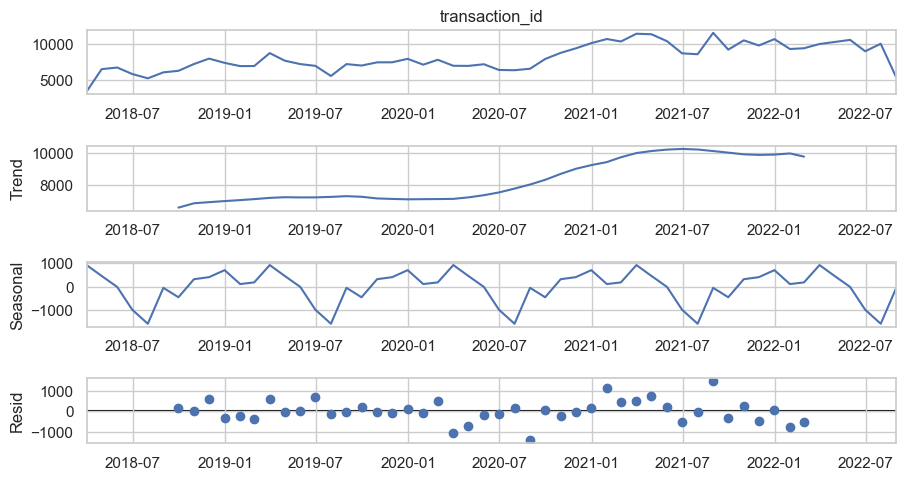

In [25]:
ssnl_trend = seasonal_decompose(data_f.set_index('date')['transaction_id'].resample('M').count())
fig = ssnl_trend.plot()
fig.set_size_inches((10, 5));

/var/folders/_v/dyjxzry12wv9hvkyc07kd4300000gn/T/ipykernel_33612/4015399614.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


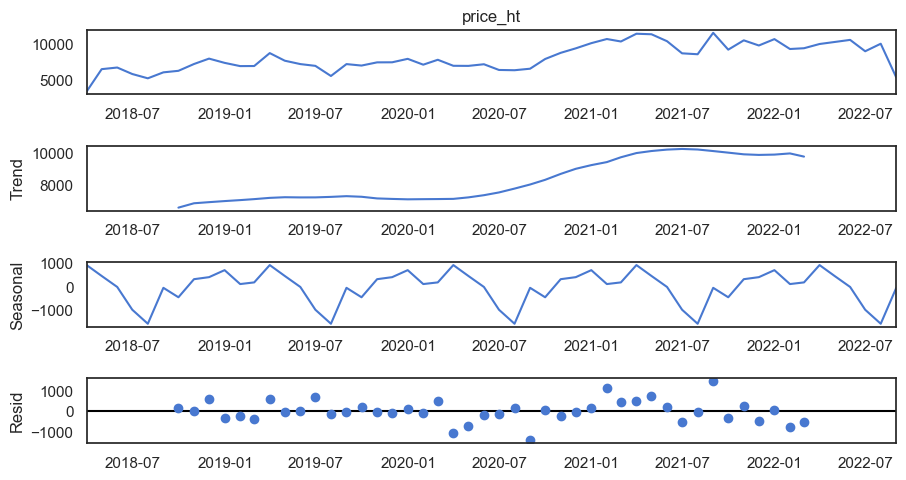

In [124]:
ssnl_trend = seasonal_decompose(data_f.set_index('date')['price_ht'].resample('M').count())
fig = ssnl_trend.plot()
fig.set_size_inches((10, 5))
ax.set(title="A",)
# fig.savefig('pics/trends.png');

We can see, that for `price_ht` and `transaction_id` we have the same seasonality (more sales in winter). Probably, because of holidays

# Potential Areas to Improve

1. Variance in price for particular goods
2. Map `item_id` with real names to make some reasonable conclusions about observed insights
3. Add more features (holiday, weather, days before/after Christmas, etc.)
4. More bakeries to check if trends are common
5. Make more advanced time series analysis (it is possible to get more insights from trends?)